In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, StandardScaler, RobustScaler, Normalizer, QuantileTransformer, PowerTransformer
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import timeit
from matplotlib import pyplot as plt
import warnings
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.pipeline import Pipeline
import itertools
from sklearn.model_selection import GridSearchCV
import os

In [49]:
warnings.filterwarnings("ignore")

**Khởi tạo bộ scalers**

In [54]:
# Standardization techniques
scalers = [MinMaxScaler(), MaxAbsScaler(), StandardScaler(), RobustScaler(), QuantileTransformer(), Normalizer(), PowerTransformer()]

**Hàm thử nghiệm để tìm ra thuật toán tối ưu cho bài toán**

In [52]:
def test(data, models):  
    
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    X = data.drop('team_win', axis=1)
    y = data['team_win']
    
    model_list = []

    # Loop through models and scalers
    for model in models:
        elapsed_time = {}
        acc_scores = {}
        for scaler in scalers:
            start_time = timeit.default_timer()
            acc = []
            
            # Scale the data
            X_scaled = scaler.fit_transform(X)
            
            # Loop through folds and calculate average accuracy
            for train_index, test_index in kf.split(X_scaled):
                X_train_scaled, X_test_scaled = X_scaled[train_index], X_scaled[test_index]
                y_train, y_test = y[train_index], y[test_index]
                
                # Train the model
                model.fit(X_train_scaled, y_train)
                
                # Make predictions on the testing data
                y_pred = model.predict(X_test_scaled)
                
                # Calculate the accuracy of the predictions
                acc.append(accuracy_score(y_test, y_pred))
            
            # Append the accuracy score to the list for this model and scaler
            model_name = f"{type(model).__name__} ({type(scaler).__name__})"
            acc_scores[model_name] = np.mean(acc)
            elapsed_time[model_name] = timeit.default_timer() - start_time
        
        best_model_name = max(acc_scores, key=acc_scores.get)
        model_list.append((best_model_name, acc_scores[best_model_name], elapsed_time[best_model_name]))
        
    sorted_models = sorted(model_list, key=lambda x: (-x[1], x[2]))
        
    return sorted_models[0]
    

**Thử nghiệm trên tập dữ liệu 1k samples và 10k samples đã qua xử lý**

*1. Khởi tạo bộ models thử nghiệm*

In [56]:
models = [LogisticRegression(random_state=42), LinearDiscriminantAnalysis(), SVC(random_state=42)
          , RandomForestClassifier(random_state=42), DecisionTreeClassifier(random_state=42), XGBClassifier(random_state=42), GaussianNB(),
          GradientBoostingClassifier(random_state=42), AdaBoostClassifier(random_state=42), BaggingClassifier(random_state=42),
          KNeighborsClassifier()]

*2. Thử nghiệm để tìm mô hình tốt nhất trên 10 tập dữ liệu 1k samples*

In [85]:
for i in range(10):
    filename = f"data/data extracted/data_fe_1000_part_{i+1}.csv"
    data = pd.read_csv(filename)
    print("File ", filename, "- Best model: ", test(data, models)[0], "- Accuracy: ", test(data, models)[1], "- Eslaped_time: ", test(data, models)[2])

File  data/data extracted/data_fe_1000_part_1.csv - Best model:  LinearDiscriminantAnalysis (PowerTransformer) - Accuracy:  0.7689999999999999 - Eslaped_time:  0.040635200013639405
File  data/data extracted/data_fe_1000_part_2.csv - Best model:  LogisticRegression (PowerTransformer) - Accuracy:  0.758 - Eslaped_time:  0.04648220000672154
File  data/data extracted/data_fe_1000_part_3.csv - Best model:  LinearDiscriminantAnalysis (MinMaxScaler) - Accuracy:  0.742 - Eslaped_time:  0.016346799995517358
File  data/data extracted/data_fe_1000_part_4.csv - Best model:  LogisticRegression (RobustScaler) - Accuracy:  0.7649999999999999 - Eslaped_time:  0.025766300008399412
File  data/data extracted/data_fe_1000_part_5.csv - Best model:  LinearDiscriminantAnalysis (QuantileTransformer) - Accuracy:  0.786 - Eslaped_time:  0.02564380000694655
File  data/data extracted/data_fe_1000_part_6.csv - Best model:  LogisticRegression (StandardScaler) - Accuracy:  0.769 - Eslaped_time:  0.024264900013804436

*3. Thử nghiệm để tìm mô hình tốt nhất trên tập dữ liệu 10k samples*

3.1. Thử nghiệm trên tập dữ liệu không xử lý ngoại lệ

In [58]:
data = pd.read_csv("data/data_fe.csv")
print("Best model for 10k samples (not outlier handling): ", test(data, models)[0], "- Accuracy: ", test(data, models)[1], "- Eslaped_time: ", test(data, models)[2])

Best model for 10k samples (not outlier handling):  LogisticRegression (RobustScaler) - Accuracy:  0.764476239732218 - Eslaped_time:  0.07064970000647008


3.2. Thử nghiệm trên tập dữ liệu đã xử lý ngoại lệ

In [ ]:
models = [LogisticRegression(random_state=42)]
data = pd.read_csv("data/data_fe_cleaned.csv")
print("Best model for 10k samples (outlier handling): ", test(data, models)[0], "- Accuracy: ", test(data, models)[1], "- Eslaped_time: ", test(data, models)[2])

Best model for 10k samples:  LogisticRegression (MaxAbsScaler) - Accuracy:  0.7640100250626566 - Eslaped_time:  0.2432501000002958


***Nhận xét:***

1. *LinearDiscriminantAnalysis cho tỉ lệ chính xác và thời gian xử lý nhanh nhất trong trường hợp tập dữ liệu nhỏ (thử nghiệm trên 10 file 1k samples)*

2. *LogisticRegression cho tỉ lệ chính xác và thời gian xử lý vượt trội hơn so với các mô hình còn lại trong trường hợp tập dữ liệu lớn (thử nghiệm trên file 10k samples)*

3. *Kết quả thử nghiệm cho thấy việc xử lý ngoại lệ là không cần thiết (làm giảm độ chính xác từ 0.7645 xuống 0.7640)*

***-->*** ***Nên sử dụng LinearDiscriminantAnalysis cho trường hợp dữ liệu nhỏ (1k samples) và LogisticRegression cho trường hợp dữ liệu lớn (10k samples), không cần xử lý ngoại lệ***

**Thử nghiệm loại bớt đặc trưng trên bộ dữ liệu đã xử lý với 2 mô hình được chọn**

*Hàm lựa chọn đặc trưng dựa trên 2 tập dữ liệu*

In [89]:
def feature_selection(file_data, model_for_data, min_acc_score):
    data = pd.read_csv(file_data)

    # Danh sách các trường bạn muốn giữ nguyên
    keep_columns = ['team_win', 'kda_difference_top', 'kda_difference_jungle', 'kda_difference_mid', 'kda_difference_ad', 'kda_difference_sp']
    # Danh sách các trường bạn muốn bỏ đi
    drop_columns = [col for col in data.columns if col not in keep_columns]

    # Duyệt qua các tổ hợp các đặc trưng bằng cách bỏ đi từ 1 đến n đặc trưng
    results = []
    for i in range(1, len(drop_columns)+1):
        for subset in itertools.combinations(drop_columns, i):
            # Bỏ đi các đặc trưng trong tổ hợp hiện tại
            subset_indices = [drop_columns.index(feature) for feature in subset]
            subset_data = data.drop(columns=[drop_columns[i] for i in subset_indices])
            model = test(subset_data, model_for_data)[0]
            acc_score = test(subset_data, model_for_data)[1]
            eslaped_time = test(subset_data, model_for_data)[2]
            results.append((subset, model, acc_score, eslaped_time))

    sorted_models = sorted(results, key=lambda x: x[2], reverse=True)
    if (sorted_models[0][2] >= min_acc_score):
        print(f"{sorted_models[0][0]} - Model: {sorted_models[0][1]} - Acc Score: {sorted_models[0][2]*100:.4f}% - Eslaped Time: {sorted_models[0][3]}")
    else:
        print(None)


*1. Khởi tạo lại bộ mô hình đã chọn: LinearDiscriminantAnalysis cho tập dữ liệu 1k samples, Logistic Regression cho tập dữ liệu 10k samples*

In [38]:
model_for_1ksamples = [LinearDiscriminantAnalysis()]
model_for_10ksamples = [LogisticRegression()]

*2. Thử nghiệm lựa chọn đặc trưng: loại bỏ từng tổ hợp để xem kết quả sau loại bỏ thì độ chính xác có cao hơn không*

In [91]:
print("File data_fe_1000_part_1.csv")
feature_selection('data/data extracted/data_fe_1000_part_1.csv', model_for_1ksamples, test(data, model_for_1ksamples)[1])

print("File data_fe.csv")
feature_selection("data/data_fe.csv", model_for_10ksamples, test(data, model_for_10ksamples)[1])

File data_fe_1000_part_1.csv
('turret_difference',) - Model: LinearDiscriminantAnalysis (PowerTransformer) - Acc Score: 76.9000% - Eslaped Time: 0.04406469999230467
File data_fe.csv
('turret_difference', 'score_lane') - Model: LogisticRegression (StandardScaler) - Acc Score: 76.4876% - Eslaped Time: 0.06923869997262955


*3. Xóa các đặc trưng không cần thiết để tăng độ chính xác của tập dữ liệu*

In [26]:
data = pd.read_csv("data/data extracted/data_fe_1000_part_1.csv")
data = data.drop(columns=['turret_difference'], axis=1)
data.insert(0, "sequence_number", range(1, len(data) + 1))
data.to_csv("data/data_1k_featureselection.csv")

In [27]:
data = pd.read_csv("data/data_fe.csv")
data = data.drop(columns=['turret_difference', 'score_lane'], axis=1)
data.insert(0, "sequence_number", range(1, len(data) + 1))
data.to_csv("data/data_10k_featureselection.csv")

*4. Định nghĩa pineline tốt nhất*

In [40]:
best_pineline_for_1ksamples = Pipeline([
    ('scaler', PowerTransformer()),
    ('model', LinearDiscriminantAnalysis ())
])

best_pineline_for_10ksamples = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LogisticRegression  ())
])

***Nhận xét:***
1. *Đối với tập dữ liệu 1k samples, việc loại bỏ bớt các đặc trưng không cần thiết có thể làm tăng độ chính xác (từ 76.4 lên 76.8), tuy nhiên không nhiều.*
2. *Đối với tập dữ liệu 10k samples, việc loại bỏ đặc trưng không làm tăng độ chính xác, chỉ giảm*
**-->** *Tạo lại tập dữ liệu mới cho 1k samples sau khi feature selection, sử dụng dữ liệu này để tính tỉ lệ thắng và giữ nguyên tập dữ liệu cũ cho 10k samples*

**Trực quan hóa dữ liệu trước và sau khi scale**

*Hàm trực quan hóa dữ liệu trước và sau khi scaler*

In [24]:
def plot_scaled_data(file_path, scaler):
    # Đọc dữ liệu từ file CSV
    data = pd.read_csv(file_path)

    # Thiết lập cột "sequence_number" làm chỉ số hàng
    data.set_index('sequence_number', inplace=True)

    # Tạo đối tượng axes
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    # Xử lý dữ liệu
    X = data.drop(['team_win'], axis=1)
    y = data['team_win']

    # Fit scaler vào dữ liệu
    scaler.fit(X)
    X_scaled = scaler.transform(X)

    # Vẽ dữ liệu ban đầu
    axes[0].scatter(X.iloc[:, 0].values, X.iloc[:, 1].values)
    axes[0].set_title("Dữ liệu ban đầu")
    axes[0].set_xlabel("X1")
    axes[0].set_ylabel("X2")

    # Vẽ dữ liệu sau khi Scale
    axes[1].scatter(X_scaled[:, 0], X_scaled[:, 1])
    axes[1].set_title("Dữ liệu sau khi Scale")
    axes[1].set_xlabel("Scaled X1")
    axes[1].set_ylabel("Scaled X2")

    plt.tight_layout()
    plt.show()


*1. Trực quan hóa dữ liệu trên file 1k samples*

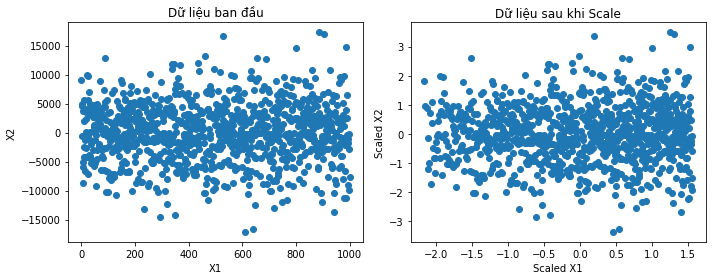

In [28]:
plot_scaled_data('data/data_1k_featureselection.csv', PowerTransformer())

*2. Trực quan hóa dữ liệu trên file 10k samples*

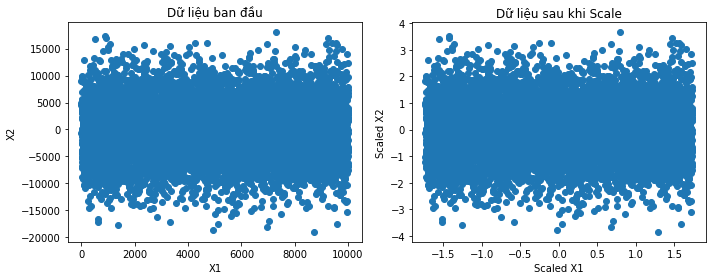

In [29]:
plot_scaled_data('data/data_10k_featureselection.csv', StandardScaler())

**Xây dựng mô hình tính tỉ lệ thắng cho mỗi trận LOL sử dụng 5 fold cross validation trên các tập dữ liệu 1k và 10k. Tính AUC để đánh giá tỉ lệ dự đoán của mô hình**

*Hàm tính tỷ lệ thắng với Kfolds validation và đánh giá bằng AUC*

In [30]:
def AUC_roc(models, model_names, data):
    dfs = []
    X = data.drop(['team_win', 'sequence_number'], axis=1)
    y = data['team_win']
    j = 0

    elapsed_times = 0
    X_cols = X.columns.tolist()

    for i, model in enumerate(models):
        auc_scores = []
        X = model[0].fit_transform(X)
        kf = KFold(n_splits=5, shuffle=True, random_state=42)
        for j, (train_index, test_index) in enumerate(kf.split(X)):
            start_time = timeit.default_timer()
            X_train_scaled, X_test_scaled = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            
            if isinstance(model[1], LogisticRegression):
                clf = LogisticRegression(random_state=42)
            elif isinstance(model[1], LinearDiscriminantAnalysis):
                clf = LinearDiscriminantAnalysis()
            
            clf.fit(X_train_scaled, y_train)
                    
            y_pred = clf.predict(X_test_scaled)
            
            # Predict the win probability for the test set
            win_prob = clf.predict_proba(X_test_scaled)[:, 1]
            
            elapsed_time = timeit.default_timer() - start_time

            # Convert win probability to win percentage
            win_percentages = win_prob * 100
            auc_score = roc_auc_score(y_test, win_prob)
            
            auc_scores.append(auc_score)

            elapsed_times  = elapsed_times+ elapsed_time
        
        print(f"Mean AUC Score for model {model}: {np.mean(auc_scores)}, Elapsed_time: {elapsed_times}")
    #return the list of dataframe result
    return dfs

*Tính tỷ lệ thắng và đánh giá AUC trên file 1k samples*

In [31]:
data = pd.read_csv("data/data_1k_featureselection.csv")

df_result = AUC_roc([(PowerTransformer(), LinearDiscriminantAnalysis())], ["LinearDiscriminantAnalysis"], data)

for i, df in enumerate(df_result):
    df.to_csv(f'data/results/result_for_LinearDiscriminantAnalysis()_part_{i}.csv', index=False)

Mean AUC Score for model (PowerTransformer(), LinearDiscriminantAnalysis()): 0.853579668152815, Elapsed_time: 0.0260144000640139


*Tính tỷ lệ thắng và đánh giá AUC trên file 10k samples*

In [32]:
data = pd.read_csv("data/data_10k_featureselection.csv")

df_result = AUC_roc([(StandardScaler(), LogisticRegression())], "StandardScaler", data)

for i, df in enumerate(df_result):
    df.to_csv(f'data/results/result_for_10k/10ksamples_Logistic Regression_part_{i}.csv', index=False)

Mean AUC Score for model (StandardScaler(), LogisticRegression()): 0.8497093485548678, Elapsed_time: 0.05830720002995804


**Tìm bộ tham số tối ưu cho mô hình**

*Hàm tìm bộ tham số tối ưu*

In [56]:
def find_best_parameters(data_file, pipeline, param_grid, output_file):
    # Load the data
    data = pd.read_csv(data_file)
    
    # Split the data into features (X) and target (y)
    X = data.drop(['team_win', 'sequence_number'], axis=1)
    y = data['team_win']
    
    # Perform grid search with k-fold cross-validation
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    grid_search = GridSearchCV(pipeline, param_grid, cv=kfold, scoring='roc_auc')
    grid_search.fit(X, y)
    
    # Print the best parameters and the corresponding AUC score
    print("Best Parameters:", grid_search.best_params_)
    print("Best AUC:", grid_search.best_score_)
    
    # Evaluate the best model on each fold and save the predictions to the output file
    fold_aucs = []
    with open(output_file, 'w') as file:
        file.write("sequence_number,team_win,win_prob\n")  # Write header to the file
        for train_index, test_index in kfold.split(X):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
            
            best_model = grid_search.best_estimator_
            win_prob = best_model.predict_proba(X_test)[:, 1]
            auc = roc_auc_score(y_test, win_prob)
            fold_aucs.append(auc)
            
            # Write predictions to the file
            for i in range(len(y_test)):
                file.write(f"{data['sequence_number'].iloc[test_index[i]]},{y_test.iloc[i]},{win_prob[i]}\n")
    
    # Calculate and print the mean AUC across folds
    mean_auc = np.mean(fold_aucs)
    print("Mean AUC:", mean_auc)


*Hàm vẽ ROC Curve*

In [36]:
def plot_roc_curve_from_files(file_paths, labels):
    # Iterate over the file paths and labels
    for file_path, label in zip(file_paths, labels):
        # Load the result data from the CSV file
        result = pd.read_csv(file_path)

        # Calculate ROC curve and AUC
        fpr, tpr, _ = roc_curve(result['team_win'], result['win_prob'])
        roc_auc = auc(fpr, tpr)

        # Plot the ROC curve with file name annotation and different colors
        plt.plot(fpr, tpr, lw=2, label='ROC curve (AUC = %0.2f) - %s' % (roc_auc, label))

    # Set plot properties
    plt.legend(loc="lower right")
    plt.title('Receiver Operating Characteristic')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

    # Show the plot with multiple ROC curves
    plt.show()


*Tìm bộ tham số tối ưu cho mô hình với tập dữ liệu 1k samples*

In [57]:
param_grid_lda = {
        'model__solver': [ 'lsqr', 'eigen'],
        'model__shrinkage': ['auto', None],
    }

find_best_parameters('data/data_1k_featureselection.csv', best_pineline_for_1ksamples, param_grid_lda, 'data/results/result_1.csv')

Best Parameters: {'model__shrinkage': 'auto', 'model__solver': 'lsqr'}
Best AUC: 0.8535616249481766
Mean AUC: 0.8614668801512988


*Tìm bộ tham số tối ưu cho mô hình với tập dữ liệu 10k samples*

In [58]:
param_grid_logistic = {
    'model__C': [0.01, 0.1, 1.0, 10.0],
    'model__penalty': ['l1', 'l2'],
    'model__solver': ['sag', 'saga', 'liblinear']
}

find_best_parameters('data/data_10k_featureselection.csv', best_pineline_for_10ksamples, param_grid_logistic, 'data/results/result_10.csv')

Best Parameters: {'model__C': 0.1, 'model__penalty': 'l2', 'model__solver': 'saga'}
Best AUC: 0.8497386173229902
Mean AUC: 0.8507580474041243


*Vẽ ROC Curve cho 2 tập dữ liệu*

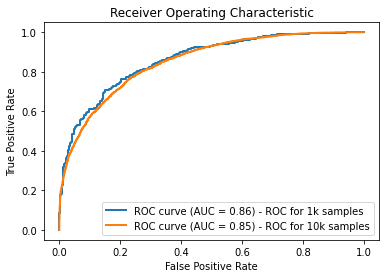

In [59]:
plot_roc_curve_from_files(['data/results/result_1.csv', 'data/results/result_10.csv'], ['ROC for 1k samples', 'ROC for 10k samples'])


**Trực quan hóa tỉ lệ thắng dự đoán**

*Hàm trực quan hóa tỉ lệ thắng*

In [60]:
def plot_blue_win_percentage(file_path, label):
    # Load the data from the CSV file
    data = pd.read_csv(file_path)

    # Extract the y values (blue_win_percentage)
    y = data['win_prob'].head(200)

    # Create a list of x values from 0 to the length of y
    x = list(range(len(y)))

    # Create a new figure
    plt.figure(figsize=(40, 6))

    # Plot the line
    plt.plot(x, y, label=label)

    # Add a legend to the graph
    plt.legend()

    # Add labels for the x and y axis
    plt.xlabel('Game Number')
    plt.ylabel('Blue Win Percentage')

    # Show the graph
    plt.show()

*Trực quan hóa tỉ lệ thắng trên 200 mẫu đầu tiên dự đoán được từ 1k mẫu*

In [81]:
def plot_blue_win_percentage(data_1, label_1, label_10):
    # Extract the y values (blue_win_percentage) for result_1
    y_1 = data_1['win_prob_result_1'].head(200)

    # Extract the y values (blue_win_percentage) for result_10
    y_10 = data_1['win_prob_result_10'].head(200)

    # Create a list of x values from 0 to the length of y_1 or y_10 (they should have the same length)
    x = list(range(len(y_1)))

    # Create a new figure
    plt.figure(figsize=(40, 6))

    # Plot the lines for result_1 and result_10
    plt.plot(x, y_1, label=label_1)
    plt.plot(x, y_10, label=label_10)

    # Add a legend to the graph
    plt.legend()

    # Add labels for the x and y axis
    plt.xlabel('Game Number')
    plt.ylabel('Blue Win Percentage')

    # Show the graph
    plt.show()


In [79]:
# Đọc dữ liệu từ file result_1
result_1 = pd.read_csv('data/results/result_1.csv')

# Đọc dữ liệu từ file result_10
result_10 = pd.read_csv('data/results/result_10.csv')

# Sắp xếp theo trường sequence_number
result_1_sorted = result_1.sort_values('sequence_number')
result_10_sorted = result_10.sort_values('sequence_number')

# Merge cột win_prob của 1k hàng đầu tiên
merged_data = pd.merge(result_1_sorted[['sequence_number', 'win_prob']].head(1000),
                       result_10_sorted[['sequence_number', 'win_prob']].head(1000),
                       on='sequence_number',
                       suffixes=('_result_1', '_result_10'))

merged_data.drop(['sequence_number'], axis=1).head(10)

,win_prob_result_1,win_prob_result_10
0,0.940901,0.957005
1,0.923986,0.895723
2,0.891666,0.849489
3,0.487528,0.419683
4,0.122981,0.081445
5,0.092046,0.121265
6,0.899875,0.870502
7,0.043271,0.027105
8,0.916314,0.918876
9,0.721880,0.697263


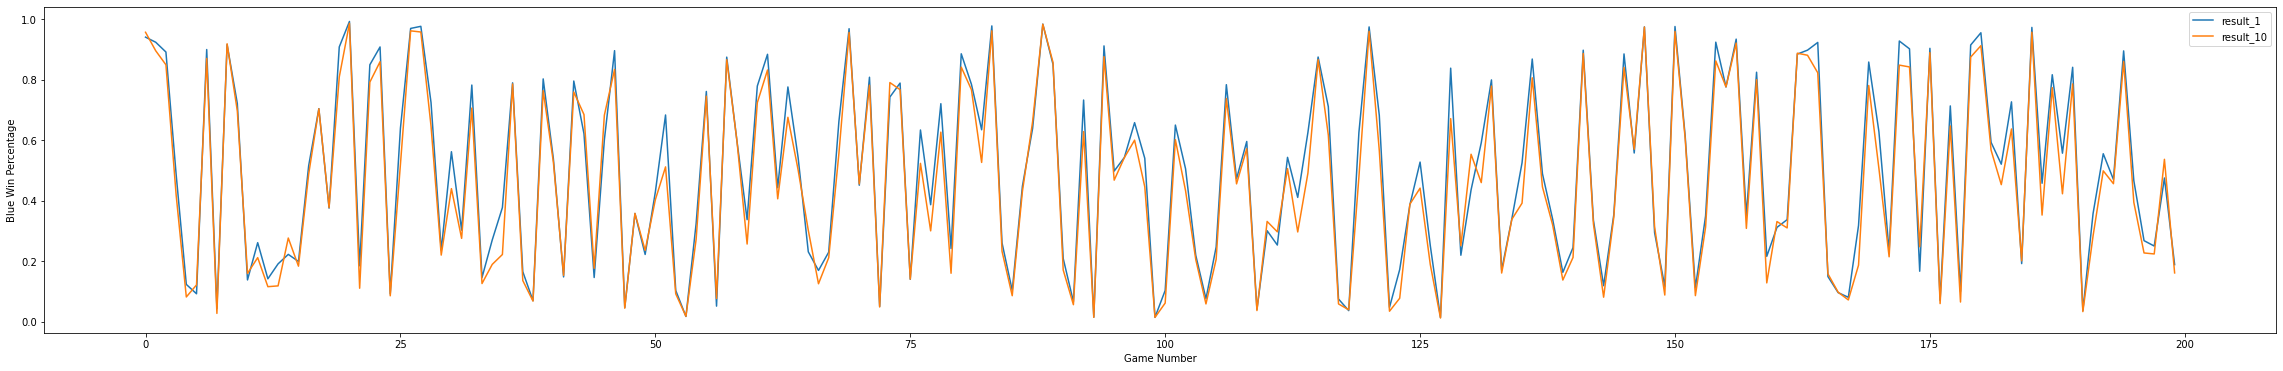

In [82]:
plot_blue_win_percentage(merged_data, 'result_1', 'result_10')